# Image Segmentation with TensorFlow

This tutorial will walk you through image segmentation using a modified [U-Net](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/) on the [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) (created by Parkhi *et al*). 

Image segmentation involves training a neural network to output a pixel-wise mask of an image. Each pixel is given a label which falls into one of three categories: 

*   Class 1 : Pixel belonging to the pet.
*   Class 2 : Pixel bordering the pet.
*   Class 3 : Surrounding pixel.

The Oxford-IIIT Pet Dataset consists of images, their corresponding labels, and pixel-wise masks.

Image segmentation has many applications, such as for medical imaging, self-driving cars and satellite imaging.

This was adapted from a TensorFlow tutorial by the TensorFlow Authors.

## Load packages

In [18]:
# !pip install -q git+https://github.com/tensorflow/examples.git
# !pip install --upgrade tensorflow keras numpy pandas sklearn pillow

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt

## Load the data

This dataset is already included in the TensorFlow datasets.

In [2]:
dataset, info = tfds.load('oxford_iiit_pet:3.2.0', with_info=True)

Here we define the functions used to preprocess and load the data. The images will be flipped and normalized to a range of [0,1]. For convenience, the pixel labels are changed from {1, 2, 3} to {0, 1, 2} by subtracting 1.

In [3]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [4]:
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [5]:
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

## Define train and test sets

In [6]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [7]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [8]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

Let's take a look at an image example and its correponding mask from the dataset:

In [9]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

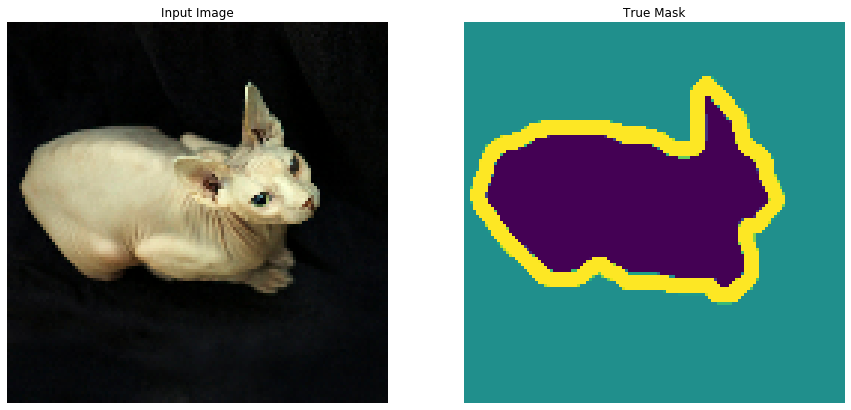

In [13]:
for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

## Build the model

The model being used here is a modified U-Net, which consists of an encoder (downsampler) and decoder (upsampler). The pretrained MobileNetV2 model is used as the encoder, and the decoder will be the upsample block already implemented in TensorFlow Examples in the [Pix2pix tutorial](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py). 

Three channels are output because there are three possible labels for each pixel (belonging to the pet, bordering the pet, or a surrounding pixel).

In [14]:
OUTPUT_CHANNELS = 3

base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


The decoder/upsampler is simply a series of upsample blocks implemented in TensorFlow examples.

In [15]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [16]:
def unet_model(output_channels):

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same', activation='softmax')  #64x64 -> 128x128

  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

## Train the model

Here we're using sparse categorical crossentropy for the loss, simply because it's the recommended loss for a scenario such as multi-class prediction. The network here is trying to assign each pixel a label, and each channel is trying to learn to predict a class. Using the output of the network, the label assigned to each pixel is the channel with the highest value. This is what the create_mask function is doing.

This will take a few minutes.

In [17]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Let's try out the model to see what it predicts before training.

In [18]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [19]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

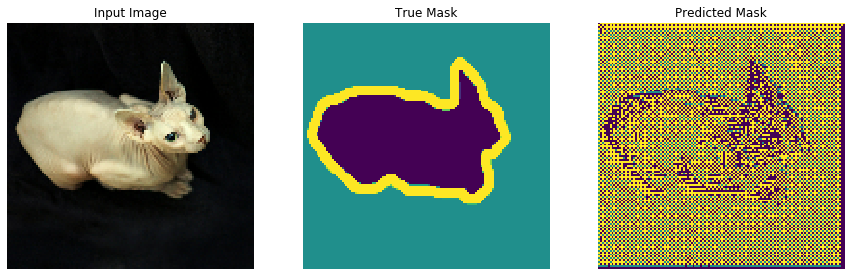

In [20]:
show_predictions()

Let's observe how the model improves while it is training. To accomplish this task, a callback function is defined below. 

In [21]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

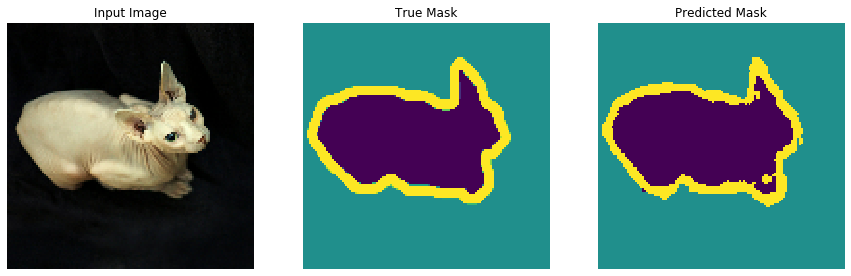


Sample Prediction after epoch 15

Epoch 16/20
56/57 [============================>.] - ETA: 1s - loss: 0.1625 - accuracy: 0.9271

In [ ]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

## Make predictions

The number of epochs is small in the interest of saving time, but this can be set higher to achieve more accurate results.

In [ ]:
show_predictions(test_dataset, 3)